In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!unrar x "/content/gdrive/My Drive/chickn_Project/datasets.rar"

In [0]:
######  Data  ##
import numpy as np
import pandas as pd
import cv2 
from sklearn.utils import shuffle
%tensorflow_version 2.x
from tensorflow.keras.utils import to_categorical
import os

def train_validation_split(X, Y, train_percent):
    val_border = np.floor(train_percent * X.shape[0]).astype(int) 
    X_train = X[:val_border, :, :, :]
    Y_train = Y[:val_border]
    X_validate = X[val_border:, :, :, :]
    Y_validate = Y[val_border: ]
    return X_train, Y_train, X_validate, Y_validate

def get_category(folder):
  if (folder == "cane"):
    category = 0 
  elif (folder == "cavallo"):
    category = 1
  elif (folder == "elefante"):
    category = 2
  elif (folder == "cane"):
    category = 1
  elif (folder == "cane"):
    category = 1
  elif (folder == "cane"):
    category = 1
  elif (folder == "cane"):
    category = 1
  elif (folder == "cane"):
    category = 1
  elif (folder == "cane"):
    category = 1
  elif (folder == "cane"):
    category = 1
    
def load_data_animals10(dims = (224, 224), base_path = ".",):
    # dims -> (h, w) 2 int tuple - output images h x w x 3
    path = base_path + "/datasets/animals10/raw-img"
    foldernames = os.listdir(path)
    
    categories = []
    files = []
    images = []
    counter = 0
    for category, folder in enumerate(foldernames):
        path_to_file = os.path.join(path, folder)
        for fname in os.listdir(path_to_file):
            files.append(os.path.join(path_to_file, fname))
            #print(os.path.join(path_to_file, fname))
            categories.append(folder)
            
            counter += 1
            if (counter <= 6):
              plt.subplot(2, 3, counter)
              img = cv2.imread(os.path.join(path_to_file, fname))
              plt.imshow(img)
              plt.ylabel(folder)
              plt.xlabel(img.shape)
            #img = Image.open(os.path.join(path_to_file, fname)
            #img = cv2.imread(os.path.join(path_to_file, fname))
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # BGR -> RGB conversion
            #img = cv2.resize(img, dims)  # resize to desired dimensions
            #images.append(img)

    #categories = to_categorical(np.array(categories), num_classes = 10)
    df = pd.DataFrame({"filename": files, "categories": categories})
    #plt.imshow(cv2.imread(df["filename"][1]))
    #print(df["categories"][1])
    #images, categories, files = shuffle(images, categories, files)    
    #X = np.array(images) / 255.0 
    #Y = np.array(categories)
    #Y = to_categorical(Y, num_classes = 10)
    #X_train, Y_train, X_val, Y_val = train_validation_split(X, Y, 0.8)
    return df 

In [0]:
######  Models  ##
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt


def model_helper(df, dims, epochs = 40, batch_size = 64):
    img_dims = (dims[0], dims[1], 3)
    model = cnn_model(dims)
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

    train_datagen = ImageDataGenerator(
        rotation_range = 25,
        width_shift_range = 0.2, 
        height_shift_range = 0.2,
        brightness_range = (-0.2, 0.2),
        horizontal_flip = True, 
        rescale = (1. / 255.),
        data_format = "channels_last"
        )

    history = model.fit(  # filename df load
        train_datagen.flow_from_dataframe(df, x_col = "filename", y_col = "categories", target_size = dims,
                                          #save_to_dir = "./test/",
                                          class_mode = "categorical", batch_size = batch_size ),
        steps_per_epoch = df.shape[0] // batch_size,
        epochs = epochs,
        callbacks = [ModelCheckpoint('VGG16-model', monitor = ['acc', 'loss'])]
    )
    #     validation_data = (X_val, Y_val),
    
    return history

def visualize_training(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.figure()
  plt.plot(epochs, acc, label = "Training Accuracy")
  plt.plot(epochs, val_acc, label = "Validation Accuracy")
  plt.title("Accuracy")

  plt.figure()
  plt.plot(epochs, loss, label = "Training Loss" )
  plt.plot(epochs, val_loss, label = "Validation Loss")
  plt.title("Loss")

  plt.figure()
  plt.plot(epochs, np.log(loss), label = "Training Loss Log" )
  plt.plot(epochs, np.log(val_loss), label = "Validation Loss Log")
  plt.title("Loss LogScale")
  return

def vgg16_model(dims):
    n_h, n_w = dims
    img_dims = (n_h, n_w, 3, )
    conv_model = applications.VGG16(include_top = False, weights = 'imagenet', input_tensor = None, input_shape = img_dims)
    for layer in conv_model.layers[:-8]:
      layer.trainable = False # Freeze all layers except last 4 
    inputs = Input(shape = img_dims)
    vgg16_conv_outputs = conv_model(inputs)
    x = Flatten(name = 'flatten')(vgg16_conv_outputs)
    x = Dense(500, activation = 'relu', name = 'fc1') (x)
    x = Dropout(0.3)(x)
    x = Dense(500, activation = 'relu', name = 'fc2') (x)
    x = Dropout(0.1)(x)
    x = Dense(10, activation = 'softmax', name = 'predictions') (x)

    model = Model(inputs = inputs, outputs = x)
    model.summary()
    return model

def cnn_model(dims):
    n_h, n_w = dims
    img_dims = (n_h, n_w, 3)
    inputs = Input(shape = img_dims)
    x = Conv2D(64, (3, 3), activation = 'tanh') (inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)
    x = Conv2D(128, (3, 3), activation = 'tanh') (x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)
    conv_nn = Model(inputs = inputs, outputs = x)

    x = conv_nn(inputs)
    x = Flatten()(x)
    x = Dense(500, activation = 'relu')(x)
    x = Dropout(0.3) (x)
    x = Dense(500, activation = 'relu')(x)
    x = Dropout(0.1) (x)
    x = Dense(10, activation = 'softmax')(x)

    end_to_end_model = Model(inputs = inputs, outputs = x)
    end_to_end_model.summary()
    return end_to_end_model

In [0]:
# Driver Program

dims = (64, 64)
df = load_data_animals10(dims)
history = model_helper(df, dims, 50, 64)
#visualize_training(history)

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
model_18 (Model)             (None, 14, 14, 128)       76416     
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 500)               12544500  
_________________________________________________________________
dropout_38 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_39 (Dropout)         (None, 500)               0  

In [13]:
df[0]

KeyError: ignored

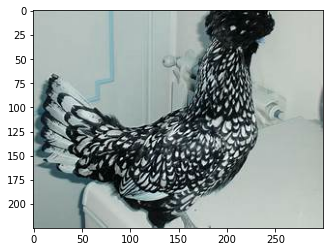

0
